# House Price Prediction EDA

### Due to the large number of independent variables, I will be focusing on ones with seemingly high importance, unique characteristics and relevance/irrelevance. The high dimensionality of this dataset will be more properly handeled in the pre-processing phase.

In [1]:
#Importing relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime, date
import numpy as np
from numpy import mean
from numpy import std
from library.sb_utils import save_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import scipy.stats as stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from library.sb_utils import save_file

In [2]:
data = pd.read_csv("Data Files/train_data_cleaned_V2.csv")

In [3]:
#Setting the first column as our dependent variable.
first_column = data.pop('SalePrice')

In [4]:
data.insert(0, 'SalePrice', first_column)

In [5]:
data.shape

(1137, 79)

In [6]:
#Checking data types of our variables, we can see there are a large number of categorical and discrete variables
#in addition to a number of continuous ones.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1137 non-null   int64  
 1   LotFrontage    1137 non-null   float64
 2   LotArea        1137 non-null   int64  
 3   MasVnrArea     1137 non-null   float64
 4   BsmtFinSF1     1137 non-null   int64  
 5   BsmtFinSF2     1137 non-null   int64  
 6   BsmtUnfSF      1137 non-null   int64  
 7   TotalBsmtSF    1137 non-null   int64  
 8   1stFlrSF       1137 non-null   int64  
 9   2ndFlrSF       1137 non-null   int64  
 10  LowQualFinSF   1137 non-null   int64  
 11  GrLivArea      1137 non-null   int64  
 12  BsmtFullBath   1137 non-null   int64  
 13  BsmtHalfBath   1137 non-null   int64  
 14  FullBath       1137 non-null   int64  
 15  HalfBath       1137 non-null   int64  
 16  BedroomAbvGr   1137 non-null   int64  
 17  KitchenAbvGr   1137 non-null   int64  
 18  TotRmsAb

Text(0, 0.5, 'Number of Homes')

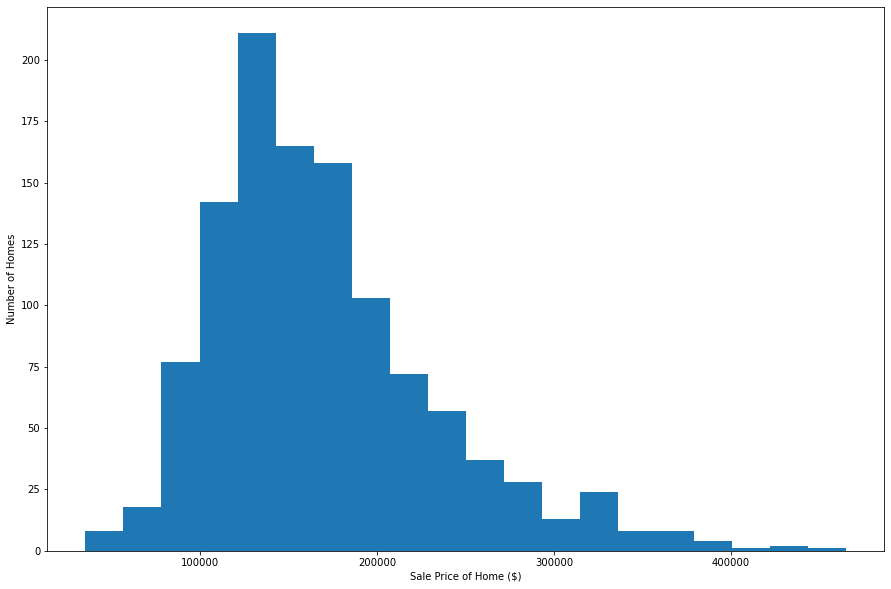

In [7]:
plt.figure(figsize=(15,10))
plt.hist(data['SalePrice'], bins=20)
plt.xlabel("Sale Price of Home ($)")
plt.ylabel("Number of Homes")

### Assessing Categorical Variables

When looking at the categorical variables we will first be visualizing them to decide if they make practical sense to include in our data set. If they pass this initial filter, we will then perform a t-test hypothesis test to see if they have a p-value significant enough to invalidate the null hypothesis: that the categorical variable does not have a meaningful correlation on the home's sale price. For categorical variables with more than 2 categories, we will use the ANOVA significance test. ANOVA requires the checking of certain assumptions to validate the significance test. One, that the categorical inputs are mutually exclusive, we will do this by applying logic and looking at their respective boxplots. The second is that of normality, which will be checked by using the Shapiro() method.

In [8]:
#Should data be grouped by or summarized by neighborhood?
neighborhood_price_means = data.groupby('Neighborhood')[['SalePrice']].mean()
print(neighborhood_price_means)

                  SalePrice
Neighborhood               
Blmngtn       194870.882353
Blueste       124000.000000
BrDale        104493.750000
BrkSide       116451.111111
ClearCr       195786.000000
CollgCr       195223.159420
Crawfor       194123.147059
Edwards       124650.000000
Gilbert       189072.342466
IDOTRR         98931.200000
MeadowV        92693.333333
Mitchel       151525.609756
NAmes         139974.813953
NPkVill       143031.250000
NWAmes        178477.019231
NoRidge       276520.000000
NridgHt       283713.296296
OldTown       114539.620253
SWISU         132984.571429
Sawyer        134857.524590
SawyerW       175587.804348
Somerst       221806.540541
StoneBr       274126.928571
Timber        239784.586207
Veenker       202333.333333


<AxesSubplot:title={'center':'Average Home Sale Price by Neighborhood'}, ylabel='Neighborhood'>

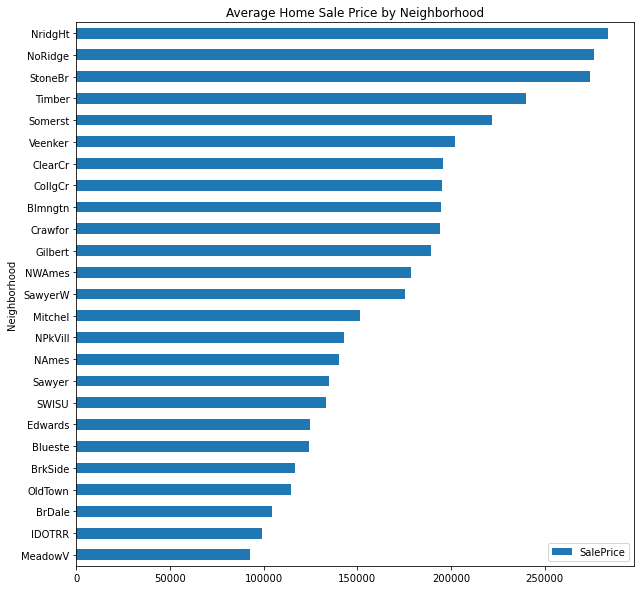

In [9]:
(neighborhood_price_means.sort_values(by='SalePrice')).plot(kind='barh',figsize=(10,10), 
                                                            title='Average Home Sale Price by Neighborhood')

There is clearly a correlation between neighborhood and sale price

In [10]:
#Creating a seperate dataframe for categorical variables
data_cat = data.select_dtypes(include='object').copy().join(data[{'MSSubClass', 'OverallQual', 'OverallCond','SalePrice'}])

In [11]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1137 non-null   object
 1   Street         1137 non-null   object
 2   Alley          1137 non-null   object
 3   LotShape       1137 non-null   object
 4   LandContour    1137 non-null   object
 5   Utilities      1137 non-null   object
 6   LotConfig      1137 non-null   object
 7   LandSlope      1137 non-null   object
 8   Neighborhood   1137 non-null   object
 9   Condition1     1137 non-null   object
 10  Condition2     1137 non-null   object
 11  BldgType       1137 non-null   object
 12  HouseStyle     1137 non-null   object
 13  RoofStyle      1137 non-null   object
 14  RoofMatl       1137 non-null   object
 15  Exterior1st    1137 non-null   object
 16  Exterior2nd    1137 non-null   object
 17  MasVnrType     1137 non-null   object
 18  ExterQual      1137 non-null

In [12]:
def stripplots(column):
    sns.catplot(x=column, y='SalePrice', kind="strip", data=data_cat)

In [13]:
def swarmplots(column):
    sns.catplot(x=column, y='SalePrice', kind="swarm", data=data_cat)

<AxesSubplot:xlabel='MSZoning', ylabel='count'>

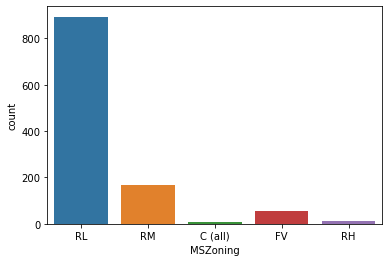

In [14]:
#Zoning countplot shows almost all observations are residential, with a majority being low-density
sns.countplot(data=data_cat, x='MSZoning')

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

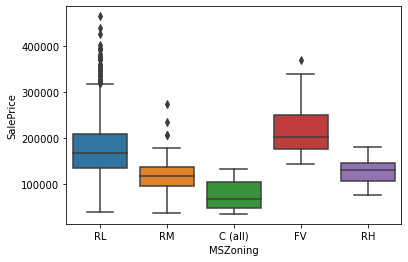

In [15]:
sns.boxplot(x='MSZoning',y='SalePrice',data=data_cat)

In [16]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ MSZoning', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
MSZoning  6.961190e+11     4.0  49.509157  2.000325e-38
Residual  3.979096e+12  1132.0        NaN           NaN

In [17]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9323204755783081, pvalue=2.8261894873516255e-22)

<AxesSubplot:xlabel='MSSubClass', ylabel='count'>

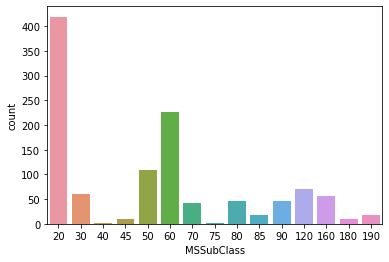

In [18]:
#Integer values given to generally classify dwelling types (ex: '1-STORY 1945 & OLDER')
sns.countplot(x='MSSubClass', data=data)

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

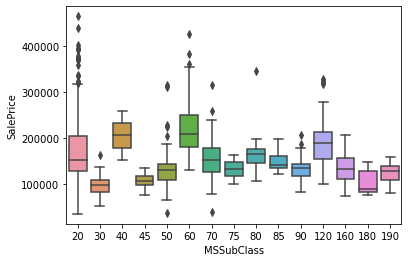

In [19]:
sns.boxplot(x='MSSubClass',y='SalePrice',data=data_cat)

In [20]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ MSSubClass', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
MSSubClass  3.293571e+10     1.0  8.052516  0.004625
Residual    4.642279e+12  1135.0       NaN       NaN

In [21]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9389766454696655, pvalue=3.3632184256706183e-21)

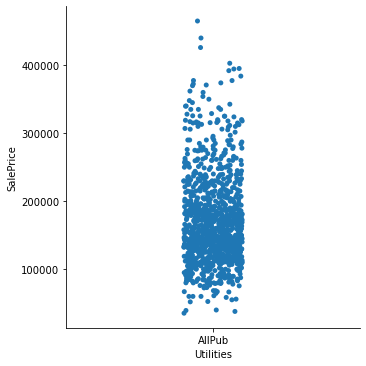

In [22]:
stripplots('Utilities')

In [23]:
#There is only one instance of the NoSeWa utilities being used, so we can remove this column from our dataset
del data['Utilities']
del data_cat['Utilities']

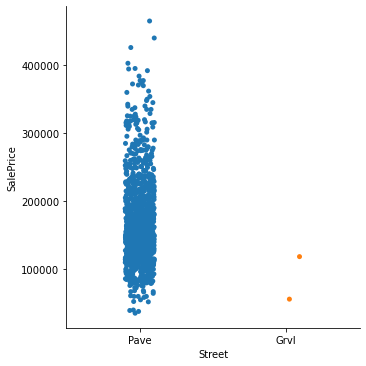

In [24]:
stripplots('Street')

In [25]:
#p-value is > 0.05 so we will deem it statistically insignificant and remove from our dataset
stats.ttest_ind(data['SalePrice'][data['Street']=='Pave'],
               data['SalePrice'][data['Street']=='Grvl'])

Ttest_indResult(statistic=1.817228059798554, pvalue=0.06944580402965035)

In [26]:
del data['Street']
del data_cat['Street']

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

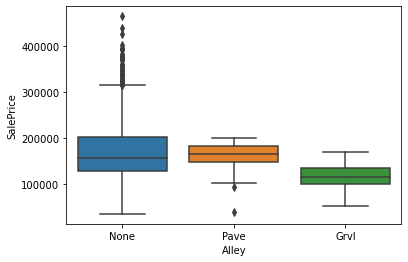

In [27]:
sns.boxplot(x='Alley',y='SalePrice',data=data_cat)

In [28]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Alley', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
Alley     1.189336e+11     2.0  14.800524  4.515182e-07
Residual  4.556281e+12  1134.0        NaN           NaN

In [29]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9376453757286072, pvalue=2.017922452400883e-21)

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

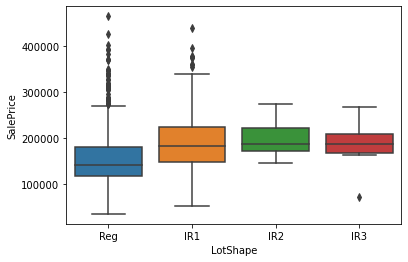

In [30]:
sns.boxplot(x='LotShape',y='SalePrice',data=data_cat)

In [31]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ LotShape', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
LotShape  2.926654e+11     3.0  25.220473  8.489897e-16
Residual  4.382549e+12  1133.0        NaN           NaN

In [32]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9251618385314941, pvalue=2.3950348774760037e-23)

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

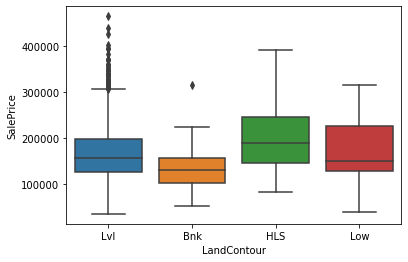

In [33]:
sns.boxplot(x='LandContour',y='SalePrice',data=data_cat)

In [34]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ LandContour', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
LandContour  1.168418e+11     3.0  9.680483  0.000003
Residual     4.558373e+12  1133.0       NaN       NaN

In [35]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9383823871612549, pvalue=2.67473213154283e-21)

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

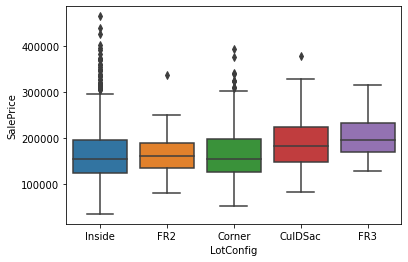

In [36]:
sns.boxplot(x='LotConfig',y='SalePrice',data=data_cat)

In [37]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ LotConfig', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
LotConfig  4.578904e+10     4.0  2.799116  0.024915
Residual   4.629426e+12  1132.0       NaN       NaN

In [38]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9321017265319824, pvalue=2.6134959265617224e-22)

<AxesSubplot:xlabel='Heating', ylabel='SalePrice'>

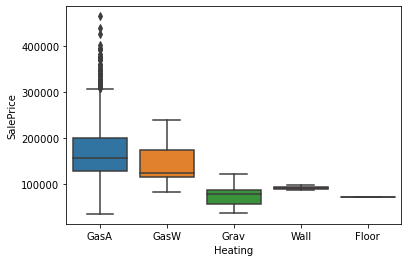

In [39]:
sns.boxplot(x='Heating',y='SalePrice',data=data_cat)

In [40]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Heating', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df        F   PR(>F)
Heating   1.040875e+11     4.0  6.44409  0.00004
Residual  4.571127e+12  1132.0      NaN      NaN

In [41]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9317117929458618, pvalue=2.274281445913363e-22)

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

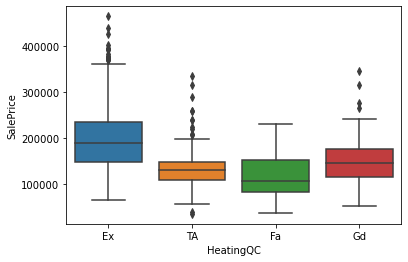

In [42]:
sns.boxplot(x='HeatingQC',y='SalePrice',data=data_cat)

In [43]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ HeatingQC', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df           F        PR(>F)
HeatingQC  1.187330e+12     3.0  128.563528  1.126503e-71
Residual   3.487885e+12  1133.0         NaN           NaN

In [44]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9550501704216003, pvalue=3.437998785835267e-18)

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice'>

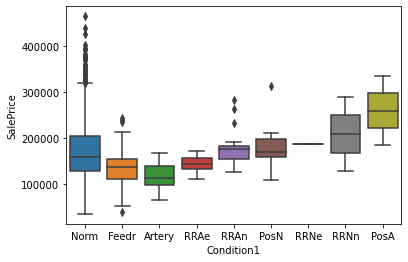

In [45]:
sns.boxplot(x='Condition1',y='SalePrice',data=data_cat)

In [46]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Condition1', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F        PR(>F)
Condition1  2.131595e+11     8.0  6.735796  1.190478e-08
Residual    4.462055e+12  1128.0       NaN           NaN

In [47]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9407774209976196, pvalue=6.80184963147386e-21)

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice'>

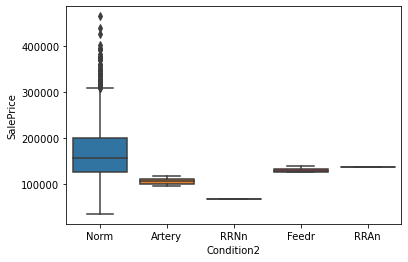

In [48]:
sns.boxplot(x='Condition2',y='SalePrice',data=data_cat)

In [49]:
#P_value does not indicate statistical significance, but since Condition2 is dependent on condition1
#should they be omited?
model = ols('SalePrice ~ Condition2', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
Condition2  2.363716e+10     4.0  1.438075  0.219197
Residual    4.651578e+12  1132.0       NaN       NaN

In [50]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9347854852676392, pvalue=6.917226685666607e-22)

In [51]:
del data['Condition2']
del data_cat['Condition2']

Condition2 are only listed for properties where another condition is already listed in Condition1.
How to handle this?

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

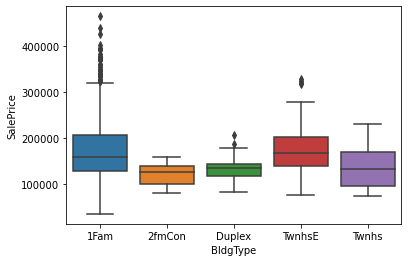

In [52]:
sns.boxplot(x='BldgType',y='SalePrice',data=data_cat)

In [53]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ BldgType', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
BldgType  1.800658e+11     4.0  11.336357  5.051191e-09
Residual  4.495149e+12  1132.0        NaN           NaN

In [54]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9422694444656372, pvalue=1.2339286649794361e-20)

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice'>

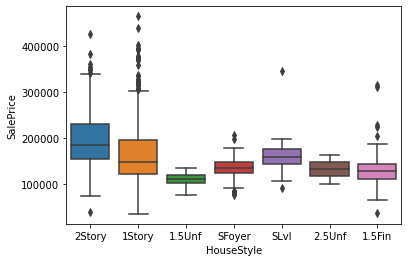

In [55]:
sns.boxplot(x='HouseStyle',y='SalePrice',data=data_cat)

In [56]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ HouseStyle', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F        PR(>F)
HouseStyle  4.720317e+11     6.0  21.15047  1.291905e-23
Residual    4.203183e+12  1130.0       NaN           NaN

In [57]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.937119722366333, pvalue=1.6529988812554004e-21)

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice'>

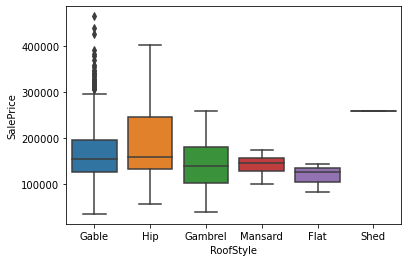

In [58]:
sns.boxplot(x='RoofStyle',y='SalePrice',data=data_cat)

In [59]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ RoofStyle', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
RoofStyle  1.051346e+11     5.0  5.203728  0.000099
Residual   4.570080e+12  1131.0       NaN       NaN

In [60]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.942202627658844, pvalue=1.2011643963453802e-20)

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice'>

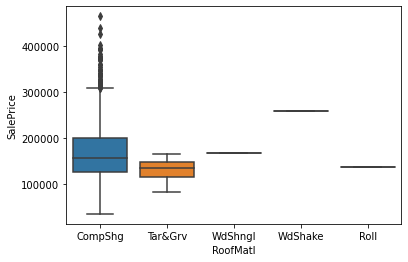

In [61]:
sns.boxplot(x='RoofMatl',y='SalePrice',data=data_cat)

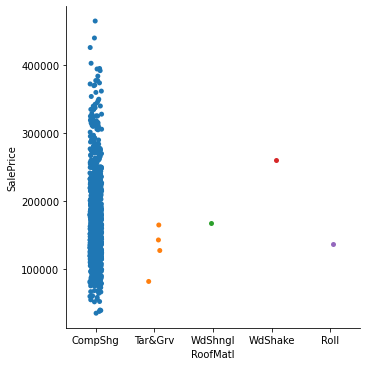

In [62]:
stripplots('RoofMatl')

In [63]:
#P_value indicates not statistically significant, will remove
model = ols('SalePrice ~ RoofMatl', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F   PR(>F)
RoofMatl  1.570216e+10     4.0  0.953686  0.43209
Residual  4.659513e+12  1132.0       NaN      NaN

In [64]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9344742298126221, pvalue=6.169624341748357e-22)

In [65]:
del data['RoofMatl']
del data_cat['RoofMatl']

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

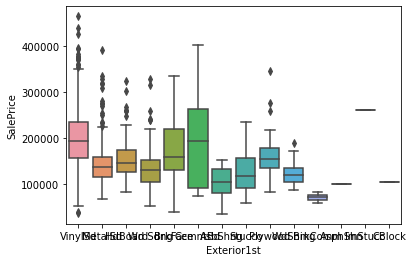

In [66]:
sns.boxplot(x='Exterior1st',y='SalePrice',data=data_cat)

In [67]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Exterior1st', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
Exterior1st  1.025809e+12    13.0  24.281783  4.596148e-52
Residual     3.649406e+12  1123.0        NaN           NaN

In [68]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9446408152580261, pvalue=3.2563816276005375e-20)

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

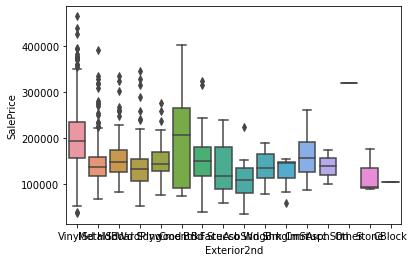

In [69]:
sns.boxplot(x='Exterior2nd',y='SalePrice',data=data_cat)

In [70]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Exterior2nd', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
Exterior2nd  9.644225e+11    15.0  19.422943  8.676919e-47
Residual     3.710792e+12  1121.0        NaN           NaN

In [71]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9451140761375427, pvalue=3.966638321864634e-20)

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

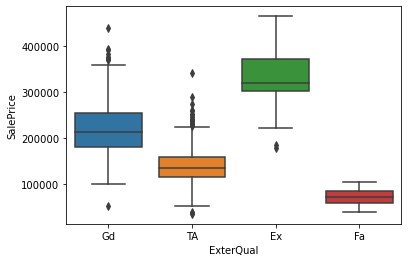

In [72]:
sns.boxplot(x='ExterQual',y='SalePrice',data=data_cat)

In [73]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ ExterQual', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df           F         PR(>F)
ExterQual  2.290518e+12     3.0  362.751398  4.447699e-165
Residual   2.384697e+12  1133.0         NaN            NaN

In [74]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9702327847480774, pvalue=1.5870885131824032e-14)

<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice'>

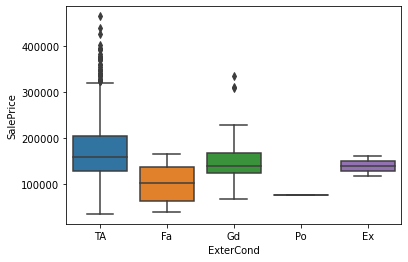

In [75]:
sns.boxplot(x='ExterCond',y='SalePrice',data=data_cat)

In [76]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ ExterCond', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
ExterCond  1.684613e+11     4.0  10.578468  2.039525e-08
Residual   4.506753e+12  1132.0        NaN           NaN

In [77]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9363585710525513, pvalue=1.2410054818865435e-21)

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

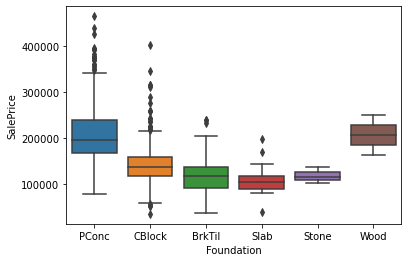

In [78]:
sns.boxplot(x='Foundation',y='SalePrice',data=data_cat)

In [79]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Foundation', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df           F        PR(>F)
Foundation  1.571053e+12     5.0  114.482462  5.248936e-98
Residual    3.104162e+12  1131.0         NaN           NaN

In [80]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9432369470596313, pvalue=1.826738071502577e-20)

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

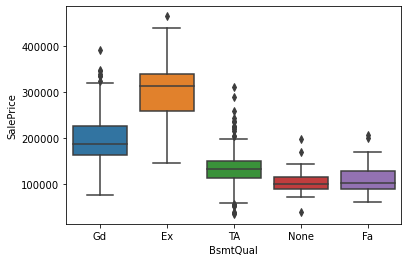

In [81]:
sns.boxplot(x='BsmtQual',y='SalePrice',data=data_cat)

In [82]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ BsmtQual', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df           F         PR(>F)
BsmtQual  2.428005e+12     4.0  305.768192  2.468117e-178
Residual  2.247210e+12  1132.0         NaN            NaN

In [83]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9777275919914246, pvalue=3.233378625608352e-12)

<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice'>

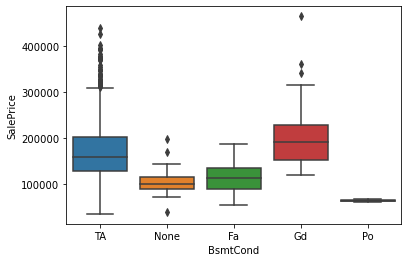

In [84]:
sns.boxplot(x='BsmtCond',y='SalePrice',data=data_cat)

In [85]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ BsmtCond', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
BsmtCond  3.342537e+11     4.0  21.790978  2.418925e-17
Residual  4.340961e+12  1132.0        NaN           NaN

In [86]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9312953352928162, pvalue=1.9617645426525792e-22)

<AxesSubplot:xlabel='BsmtExposure', ylabel='SalePrice'>

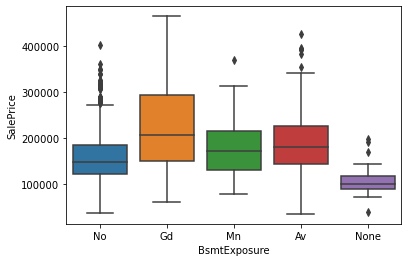

In [87]:
sns.boxplot(x='BsmtExposure',y='SalePrice',data=data_cat)

In [88]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ BsmtExposure', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
BsmtExposure  5.855157e+11     4.0  40.516659  9.252452e-32
Residual      4.089699e+12  1132.0        NaN           NaN

In [89]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9557344913482666, pvalue=4.794981136102996e-18)

<AxesSubplot:xlabel='BsmtFinType1', ylabel='SalePrice'>

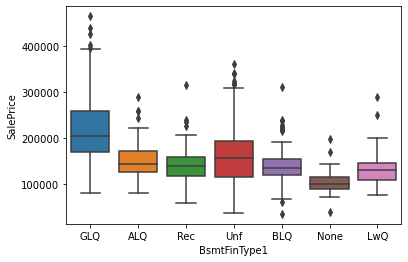

In [90]:
sns.boxplot(x='BsmtFinType1',y='SalePrice',data=data_cat)

In [91]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ BsmtFinType1', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
BsmtFinType1  1.225508e+12     6.0  66.905391  2.856097e-71
Residual      3.449707e+12  1130.0        NaN           NaN

In [92]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9622816443443298, pvalue=1.4153571147528616e-16)

<AxesSubplot:xlabel='BsmtFinType2', ylabel='SalePrice'>

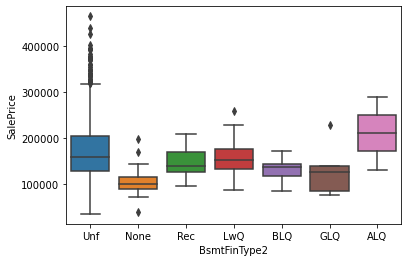

In [93]:
sns.boxplot(x='BsmtFinType2',y='SalePrice',data=data_cat)

In [94]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ BsmtFinType2', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F        PR(>F)
BsmtFinType2  2.097712e+11     6.0  8.847254  1.894570e-09
Residual      4.465443e+12  1130.0       NaN           NaN

In [95]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9403703808784485, pvalue=5.792821358407362e-21)

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

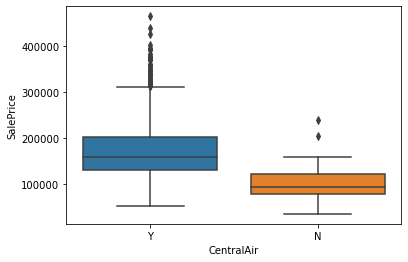

In [96]:
sns.boxplot(x='CentralAir',y='SalePrice',data=data_cat)

In [97]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ CentralAir', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
CentralAir  3.774306e+11     1.0  99.675476  1.480839e-22
Residual    4.297784e+12  1135.0        NaN           NaN

In [98]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9243408441543579, pvalue=1.825508227253918e-23)

In [99]:
#statistically significant so we will keep
stats.ttest_ind(data['SalePrice'][data['CentralAir']=='Y'],
               data['SalePrice'][data['CentralAir']=='N'])

Ttest_indResult(statistic=9.983760608109103, pvalue=1.4808393577611234e-22)

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice'>

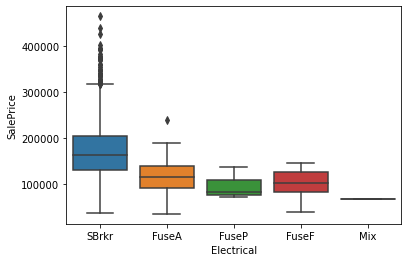

In [100]:
sns.boxplot(x='Electrical',y='SalePrice',data=data_cat)

In [101]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Electrical', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
Electrical  3.500910e+11     4.0  22.907037  3.197481e-18
Residual    4.325124e+12  1132.0        NaN           NaN

In [102]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.933993399143219, pvalue=5.174213145814069e-22)

<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

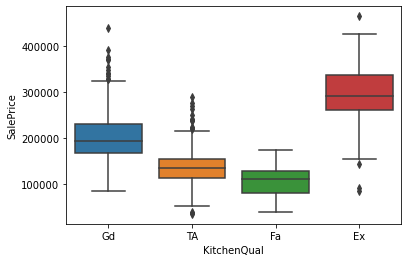

In [103]:
sns.boxplot(x='KitchenQual',y='SalePrice',data=data_cat)

In [104]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ KitchenQual', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df           F         PR(>F)
KitchenQual  2.204946e+12     3.0  337.102982  2.058376e-156
Residual     2.470268e+12  1133.0         NaN            NaN

In [105]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9698591828346252, pvalue=1.2483055733569e-14)

<AxesSubplot:xlabel='Functional', ylabel='SalePrice'>

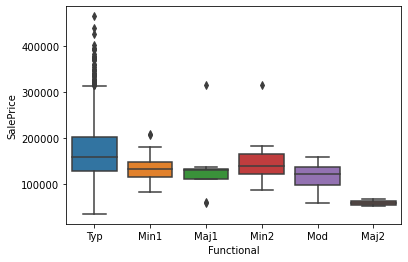

In [106]:
sns.boxplot(x='Functional',y='SalePrice',data=data_cat)

In [107]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Functional', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
Functional  1.076141e+11     5.0  5.329343  0.000076
Residual    4.567601e+12  1131.0       NaN       NaN

In [108]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9360910654067993, pvalue=1.1227234000786664e-21)

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

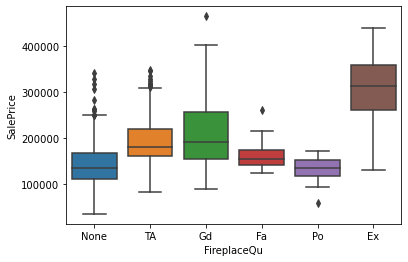

In [109]:
sns.boxplot(x='FireplaceQu',y='SalePrice',data=data_cat)

In [110]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ FireplaceQu', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
FireplaceQu  1.262823e+12     5.0  83.709801  6.743153e-75
Residual     3.412391e+12  1131.0        NaN           NaN

In [111]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.965175986289978, pvalue=7.223467857427111e-16)

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

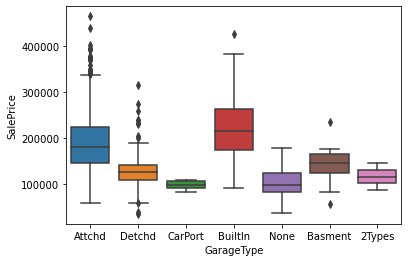

In [112]:
sns.boxplot(x='GarageType',y='SalePrice',data=data_cat)

In [113]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ GarageType', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
GarageType  1.391581e+12     6.0  79.814355  2.876910e-83
Residual    3.283634e+12  1130.0        NaN           NaN

In [114]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9367754459381104, pvalue=1.45149921884526e-21)

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

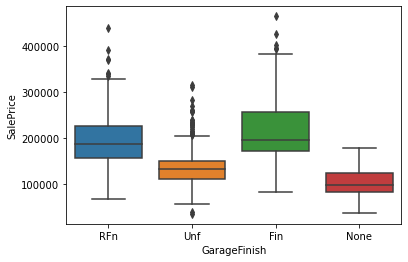

In [115]:
sns.boxplot(x='GarageFinish',y='SalePrice',data=data_cat)

In [116]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ GarageFinish', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df           F         PR(>F)
GarageFinish  1.753846e+12     3.0  226.732408  3.382196e-115
Residual      2.921369e+12  1133.0         NaN            NaN

In [117]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9422874450683594, pvalue=1.2429240925822369e-20)

<AxesSubplot:xlabel='GarageQual', ylabel='SalePrice'>

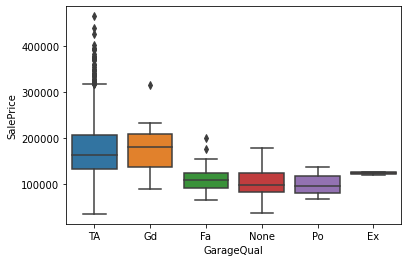

In [118]:
sns.boxplot(x='GarageQual',y='SalePrice',data=data_cat)

In [119]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ GarageQual', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
GarageQual  5.074554e+11     5.0  27.541519  2.245987e-26
Residual    4.167759e+12  1131.0        NaN           NaN

In [120]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9310259819030762, pvalue=1.7835164355169706e-22)

<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice'>

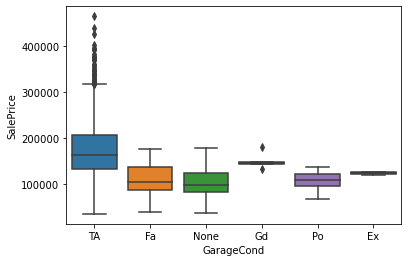

In [121]:
sns.boxplot(x='GarageCond',y='SalePrice',data=data_cat)

In [122]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ GarageCond', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
GarageCond  4.989166e+11     5.0  27.022718  6.969289e-26
Residual    4.176298e+12  1131.0        NaN           NaN

In [123]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9304423332214355, pvalue=1.4522998684878487e-22)

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

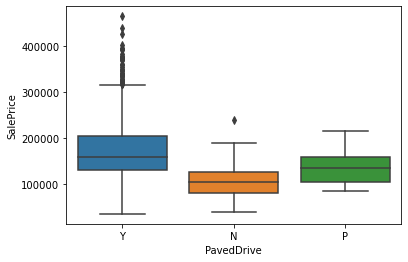

In [124]:
sns.boxplot(x='PavedDrive',y='SalePrice',data=data_cat)

In [125]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ PavedDrive', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
PavedDrive  3.216364e+11     2.0  41.889182  2.808032e-18
Residual    4.353578e+12  1134.0        NaN           NaN

In [126]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9310640692710876, pvalue=1.8076740070074795e-22)

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

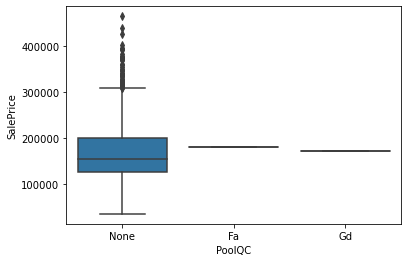

In [127]:
sns.boxplot(x='PoolQC',y='SalePrice',data=data_cat)

In [128]:
#P_value indicates not statistically significant, will omit
model = ols('SalePrice ~ PoolQC', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F    PR(>F)
PoolQC    1.340101e+08     2.0  0.016253  0.983879
Residual  4.675081e+12  1134.0       NaN       NaN

In [129]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9342308640480042, pvalue=5.643191837492175e-22)

In [130]:
del data['PoolQC']
del data_cat['PoolQC']

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

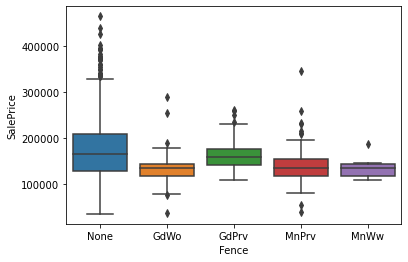

In [131]:
sns.boxplot(x='Fence',y='SalePrice',data=data_cat)

In [132]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ Fence', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
Fence     2.092570e+11     4.0  13.260251  1.460475e-10
Residual  4.465958e+12  1132.0        NaN           NaN

In [133]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9459272623062134, pvalue=5.583821332728125e-20)

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

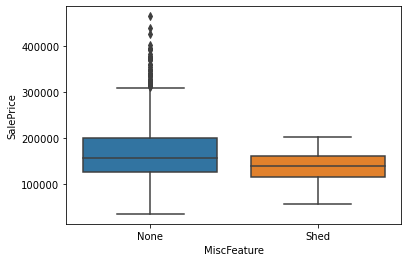

In [134]:
sns.boxplot(x='MiscFeature',y='SalePrice',data=data_cat)

In [135]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ MiscFeature', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df         F   PR(>F)
MiscFeature  3.261421e+10     1.0  7.973361  0.00483
Residual     4.642600e+12  1135.0       NaN      NaN

In [136]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9363328814506531, pvalue=1.2291047641357028e-21)

In [137]:
#statistically significant so we will keep
stats.ttest_ind(data['SalePrice'][data['MiscFeature']=='Shed'],
               data['SalePrice'][data['MiscFeature']=='None'])

Ttest_indResult(statistic=-2.823714012331106, pvalue=0.004830075606334137)

<AxesSubplot:xlabel='SaleType', ylabel='SalePrice'>

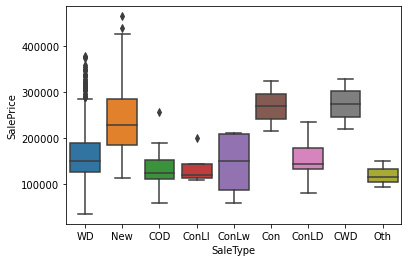

In [138]:
sns.boxplot(x='SaleType',y='SalePrice',data=data_cat)

In [139]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ SaleType', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
SaleType  6.719150e+11     8.0  23.665482  9.170105e-34
Residual  4.003300e+12  1128.0        NaN           NaN

In [140]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9462577104568481, pvalue=6.423175071217607e-20)

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice'>

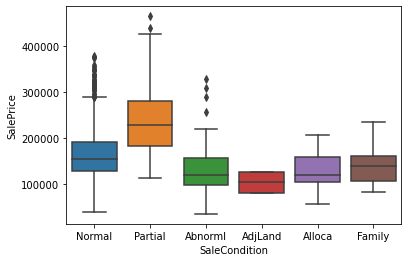

In [141]:
sns.boxplot(x='SaleCondition',y='SalePrice',data=data_cat)

In [142]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ SaleCondition', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
SaleCondition  6.709595e+11     5.0  37.902437  5.033918e-36
Residual       4.004255e+12  1131.0        NaN           NaN

In [143]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9428255558013916, pvalue=1.5451126381728213e-20)

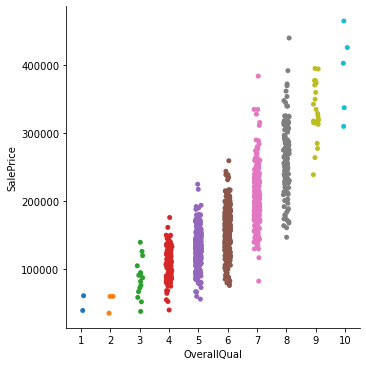

In [144]:
#Quality of the entire dwelling, subjective but also seems to have high correlation with sale price, perhaps semi-log relation
stripplots('OverallQual')

[None]

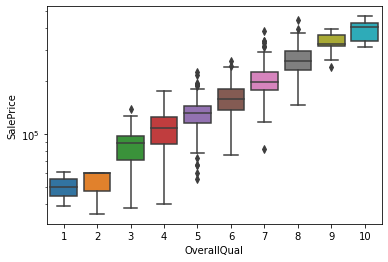

In [145]:
#semi-log boxplot of OverallQual
sns.boxplot(x='OverallQual', y='SalePrice', data=data).set(yscale="log")

In [146]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ OverallQual', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df            F         PR(>F)
OverallQual  3.089485e+12     1.0  2211.327007  9.587492e-269
Residual     1.585729e+12  1135.0          NaN            NaN

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

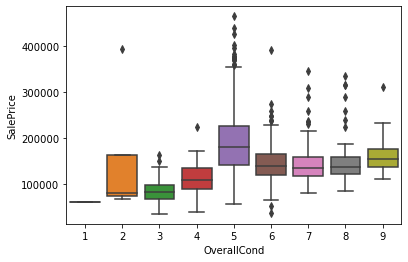

In [147]:
sns.boxplot(x='OverallCond',y='SalePrice',data=data_cat)

In [148]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ OverallCond', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F    PR(>F)
OverallCond  5.824910e+10     1.0  14.319519  0.000162
Residual     4.616966e+12  1135.0        NaN       NaN

In [149]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9446231722831726, pvalue=3.232587260292567e-20)

In [150]:
#P_value invalidates null hypothesis, so attribute will be kept.
model = ols('SalePrice ~ SaleCondition', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
SaleCondition  6.709595e+11     5.0  37.902437  5.033918e-36
Residual       4.004255e+12  1131.0        NaN           NaN

In [151]:
#Testing for the normality assumption
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9428255558013916, pvalue=1.5451126381728213e-20)

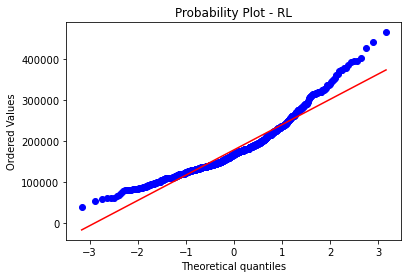

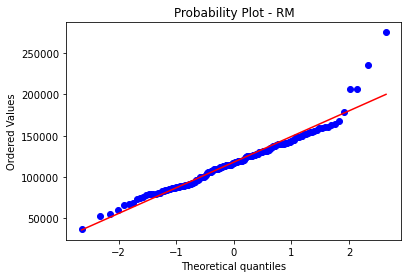

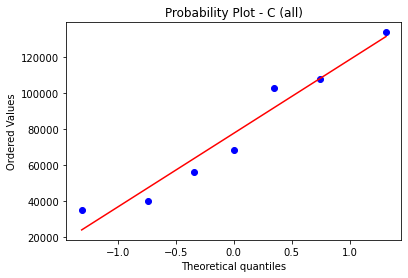

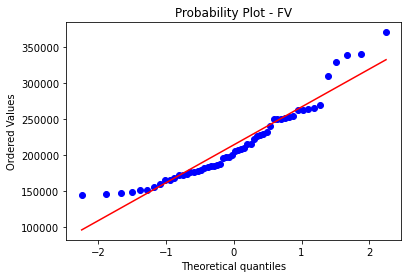

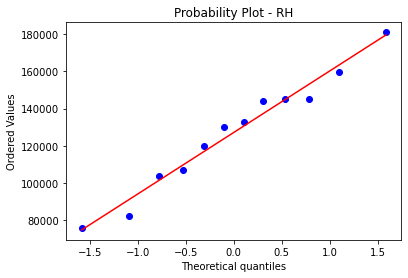

In [152]:
unique_mszoning = data_cat['MSZoning'].unique()
for mszoning in unique_mszoning:
    stats.probplot(data_cat[data_cat['MSZoning'] == mszoning]['SalePrice'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  mszoning)
    plt.show()

#### After performing statistical significance tests on all of our categorical variables, the ones that did not produce a P-value > 0.05 were omitted and are as follows:
PoolQC, RoofMatl, Condition2, Street and Utilities.

In [153]:
#We can verify the deltion by checking the df's shape
data.shape, data_cat.shape

((1137, 74), (1137, 42))

## Assessing Continuous/Numerical Variables

In [154]:
data_num = data.select_dtypes(include=['int64','float64']).copy()
data_num = data_num.drop(columns=['MSSubClass','OverallQual','OverallCond'])

In [155]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1137 non-null   int64  
 1   LotFrontage    1137 non-null   float64
 2   LotArea        1137 non-null   int64  
 3   MasVnrArea     1137 non-null   float64
 4   BsmtFinSF1     1137 non-null   int64  
 5   BsmtFinSF2     1137 non-null   int64  
 6   BsmtUnfSF      1137 non-null   int64  
 7   TotalBsmtSF    1137 non-null   int64  
 8   1stFlrSF       1137 non-null   int64  
 9   2ndFlrSF       1137 non-null   int64  
 10  LowQualFinSF   1137 non-null   int64  
 11  GrLivArea      1137 non-null   int64  
 12  BsmtFullBath   1137 non-null   int64  
 13  BsmtHalfBath   1137 non-null   int64  
 14  FullBath       1137 non-null   int64  
 15  HalfBath       1137 non-null   int64  
 16  BedroomAbvGr   1137 non-null   int64  
 17  KitchenAbvGr   1137 non-null   int64  
 18  TotRmsAb

In [156]:
data_num.describe().T

count           mean           std      min       25%  \
SalePrice      1137.0  169524.571680  64152.208863  35311.0  127000.0   
LotFrontage    1137.0      56.259455     31.245879      0.0      43.0   
LotArea        1137.0    9296.226913   3889.441844   1300.0    7200.0   
MasVnrArea     1137.0      80.530343    130.061731      0.0       0.0   
BsmtFinSF1     1137.0     423.452067    414.247374      0.0       0.0   
BsmtFinSF2     1137.0      21.046614     82.616363      0.0       0.0   
BsmtUnfSF      1137.0     560.302551    425.802252      0.0     221.0   
TotalBsmtSF    1137.0    1004.801231    378.600982      0.0     780.0   
1stFlrSF       1137.0    1104.442392    329.492638    334.0     861.0   
2ndFlrSF       1137.0     315.208443    400.866813      0.0       0.0   
LowQualFinSF   1137.0       0.257696      4.394048      0.0       0.0   
GrLivArea      1137.0    1419.908531    419.378888    334.0    1092.0   
BsmtFullBath   1137.0       0.401055      0.513136      0.0       0.0   
BsmtHalfBath   1137.0       0.056288      0.238092      0.0       0.0   
FullBath       1137.0       1.536500      0.529695      0.0       1.0   
HalfBath       1137.0       0.365875      0.498056      0.0       0.0   
BedroomAbvGr   1137.0       2.813544      0.770535      0.0       2.0   
KitchenAbvGr   1137.0       1.043975      0.213541      0.0       1.0   
TotRmsAbvGrd   1137.0       6.288478      1.417130      2.0       5.0   
Fireplaces     1137.0       0.533861      0.610174      0.0       0.0   
GarageCars     1137.0       1.720317      0.734620      0.0       1.0   
GarageArea     1137.0     455.074758    201.873162      0.0     308.0   
WoodDeckSF     1137.0      87.139842    106.272979      0.0       0.0   
OpenPorchSF    1137.0      38.905893     50.654162      0.0       0.0   
EnclosedPorch  1137.0      14.145119     42.025615      0.0       0.0   
3SsnPorch      1137.0       0.104661      2.927009      0.0       0.0   
ScreenPorch    1137.0       5.130167     25.866646      0.0       0.0   
PoolArea       1137.0       1.076517     25.700783      0.0       0.0   
MiscVal        1137.0      15.790677    102.108968      0.0       0.0   
Age_of_sale    1137.0    4919.973615    482.321825   4101.0    4496.0   
House_Age      1137.0      48.124011     29.403272     11.0      19.0   
Remod_Age      1137.0      36.160070     20.900899     11.0      17.0   
Garage_Age     1137.0      39.301671     25.945696      0.0      17.0   

                    50%       75%       max  
SalePrice      155835.0  199900.0  465000.0  
LotFrontage        62.0      76.0     153.0  
LotArea          9100.0   11000.0   36500.0  
MasVnrArea          0.0     135.0     630.0  
BsmtFinSF1        384.0     695.0    1646.0  
BsmtFinSF2          0.0       0.0     532.0  
BsmtUnfSF         476.0     801.0    1869.0  
TotalBsmtSF       953.0    1232.0    2136.0  
1stFlrSF         1044.0    1314.0    2136.0  
2ndFlrSF            0.0     689.0    1427.0  
LowQualFinSF        0.0       0.0      80.0  
GrLivArea        1395.0    1694.0    2727.0  
BsmtFullBath        0.0       1.0       3.0  
BsmtHalfBath        0.0       0.0       2.0  
FullBath            2.0       2.0       3.0  
HalfBath            0.0       1.0       2.0  
BedroomAbvGr        3.0       3.0       6.0  
KitchenAbvGr        1.0       1.0       3.0  
TotRmsAbvGrd        6.0       7.0      10.0  
Fireplaces          0.0       1.0       3.0  
GarageCars          2.0       2.0       4.0  
GarageArea        462.0     573.0    1053.0  
WoodDeckSF          0.0     168.0     436.0  
OpenPorchSF        21.0      60.0     229.0  
EnclosedPorch       0.0       0.0     198.0  
3SsnPorch           0.0       0.0      96.0  
ScreenPorch         0.0       0.0     170.0  
PoolArea            0.0       0.0     648.0  
MiscVal             0.0       0.0    1300.0  
Age_of_sale      4892.0    5288.0    5743.0  
House_Age          46.0      67.0     146.0  
Remod_Age          27.0      55.0      71.0  
Garage_Age     

Noteworthy takeaways: total rooms has a max value of 14, 

### Visualization

In [157]:
data['Remod_Age_Avg']=(data['House_Age']+data['Remod_Age'])/2
data_num['Remod_Age_Avg']=(data['House_Age']+data['Remod_Age'])/2

In [158]:
# define useful function to create scatterplots of ticket prices against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'SalePrice', data=data_num, alpha=0.5)
        ax.set(xlabel=col, ylabel='Sale Price')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [159]:
num_features = [x for x in data_num.columns if x not in ['SalePrice']]

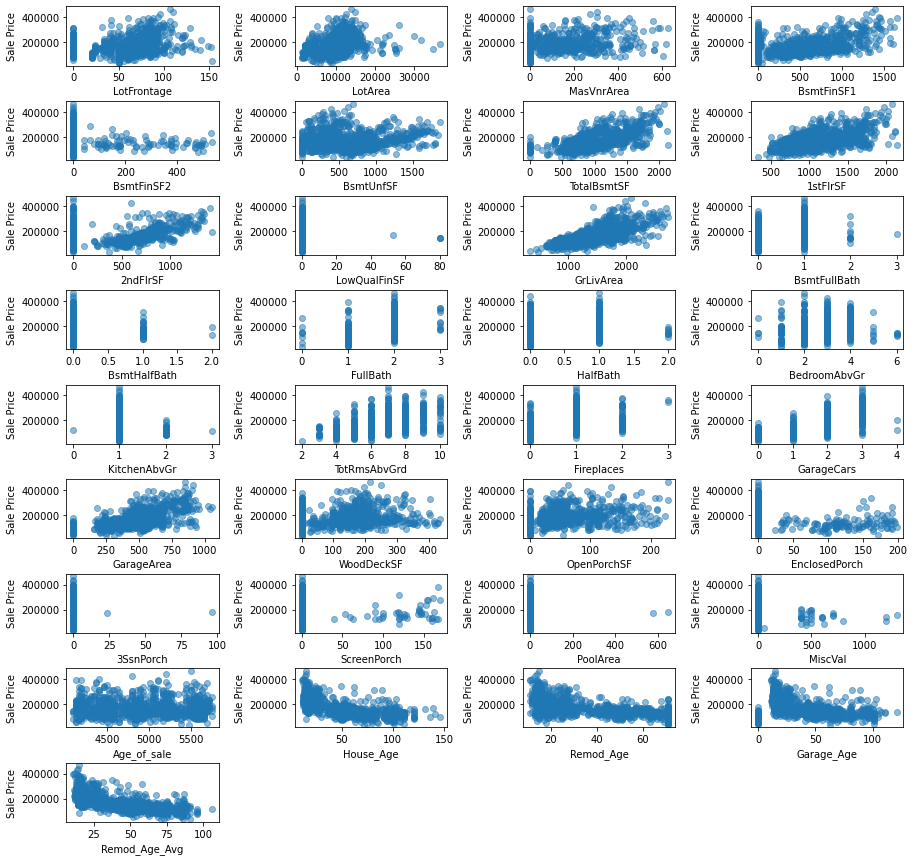

In [160]:
scatterplots(num_features, ncol=4, figsize=(15,15))

Seems DV's relationship to age-based variables is maybe logarithmic. Also worth noting is that extreme values of certain room attributes result in lower property values. Sales price declines with more than 1 half bathroom, 1 basement full bath, 4 above ground bedrooms, 1 above ground kitchen, 2 fireplaces, and 3 car garages. This relationship isn't entirely represented in TotRmsAbvGrd, however. Certain other intuitive relationships exist as well, such as finished versus unfished area. We would expect finished basements to generate more value, and the plots show that higher finished basement square footage lead to greater value than unfinished basements. A few interesting outliers seem to be present as well, such as the extreme value seen in BsmtFinSF1, 1stFlrSF as well as a house with 3 full baths in the basement and another (or the same) with 8 above ground bedrooms.

The value of certain attributes don't necessarily indicate an increase in value, such as area of the different porch types or pool areas, but perhaps houses that have these attributes are worth more than ones that don't?

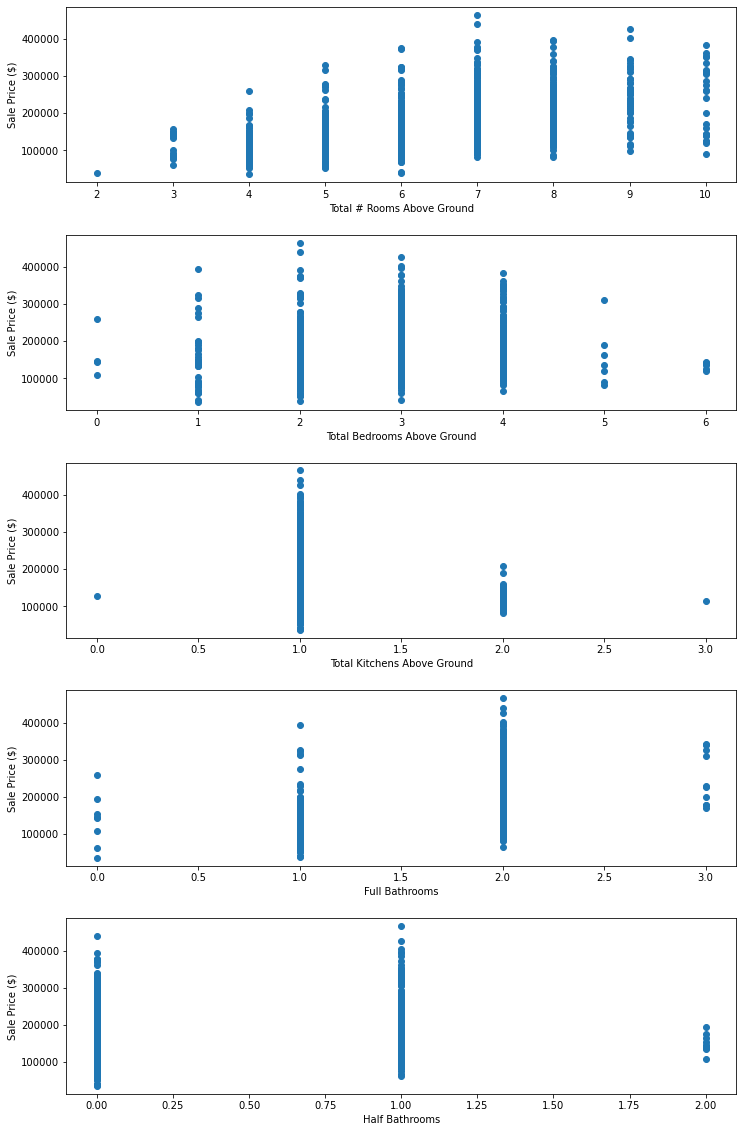

In [161]:
fig, ax = plt.subplots(5,1, sharey=True)
fig.set_size_inches([12,20])
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax[0].scatter(data_num['TotRmsAbvGrd'], data_num['SalePrice'])
ax[0].set_xlabel("Total # Rooms Above Ground")
ax[0].set_ylabel("Sale Price ($)")

ax[1].scatter(data_num['BedroomAbvGr'], data_num['SalePrice'])
ax[1].set_xlabel("Total Bedrooms Above Ground")
ax[1].set_ylabel("Sale Price ($)")

ax[2].scatter(data_num['KitchenAbvGr'], data_num['SalePrice'])
ax[2].set_xlabel("Total Kitchens Above Ground")
ax[2].set_ylabel("Sale Price ($)")

ax[3].scatter(data_num['FullBath'], data_num['SalePrice'])
ax[3].set_xlabel("Full Bathrooms")
ax[3].set_ylabel("Sale Price ($)")

ax[4].scatter(data_num['HalfBath'], data_num['SalePrice'])
ax[4].set_xlabel("Half Bathrooms")
ax[4].set_ylabel("Sale Price ($)")

plt.show()

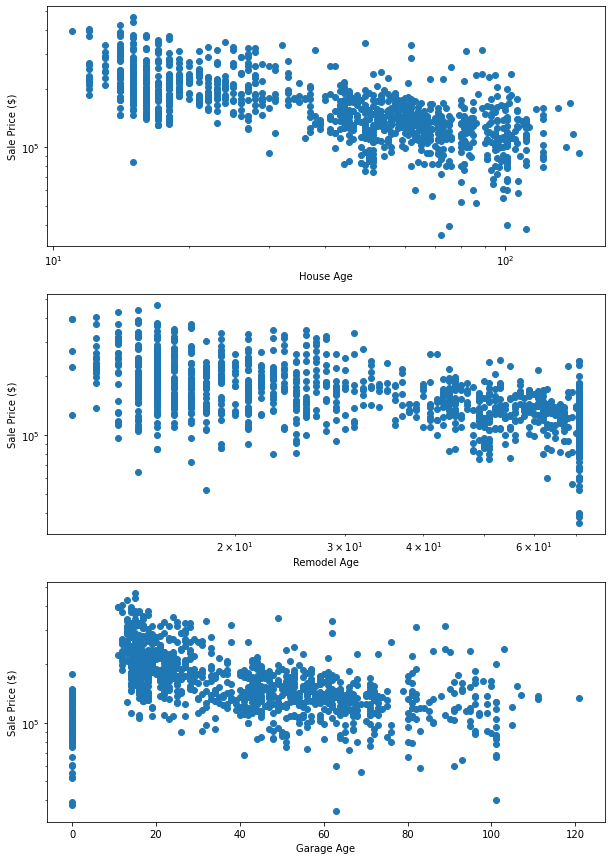

In [162]:
fig, ax = plt.subplots(3,1, sharey=True)
fig.set_size_inches([10,15])

ax[0].scatter(data_num['House_Age'], data_num['SalePrice'])
ax[0].set_xlabel("House Age")
ax[0].set_ylabel("Sale Price ($)")
ax[0].set_yscale("log")
ax[0].set_xscale("log")

ax[1].scatter(data_num['Remod_Age'], data_num['SalePrice'])
ax[1].set_xlabel("Remodel Age")
ax[1].set_ylabel("Sale Price ($)")
ax[1].set_yscale("log")
ax[1].set_xscale("log")

ax[2].scatter(data_num['Garage_Age'], data_num['SalePrice'])
ax[2].set_xlabel("Garage Age")
ax[2].set_ylabel("Sale Price ($)")
ax[2].set_yscale("log")

plt.show()

We notice a log-log relationship between these age attributes and sale price. Garage Age has a large number of zero values for houses without garages, so it is plotted on a semi-log scale.

In [163]:
#Huge number of remodels occured in 1950? Should these be included?
data.Remod_Age.value_counts()

71    141
15     78
16     66
14     65
17     53
     ... 
11      5
70      4
34      4
35      4
69      4
Name: Remod_Age, Length: 61, dtype: int64

 We also noticed a large, questionable number of remodels occuring 71 years ago, or in 1950. What is the significance of this and is it of concern?

<AxesSubplot:>

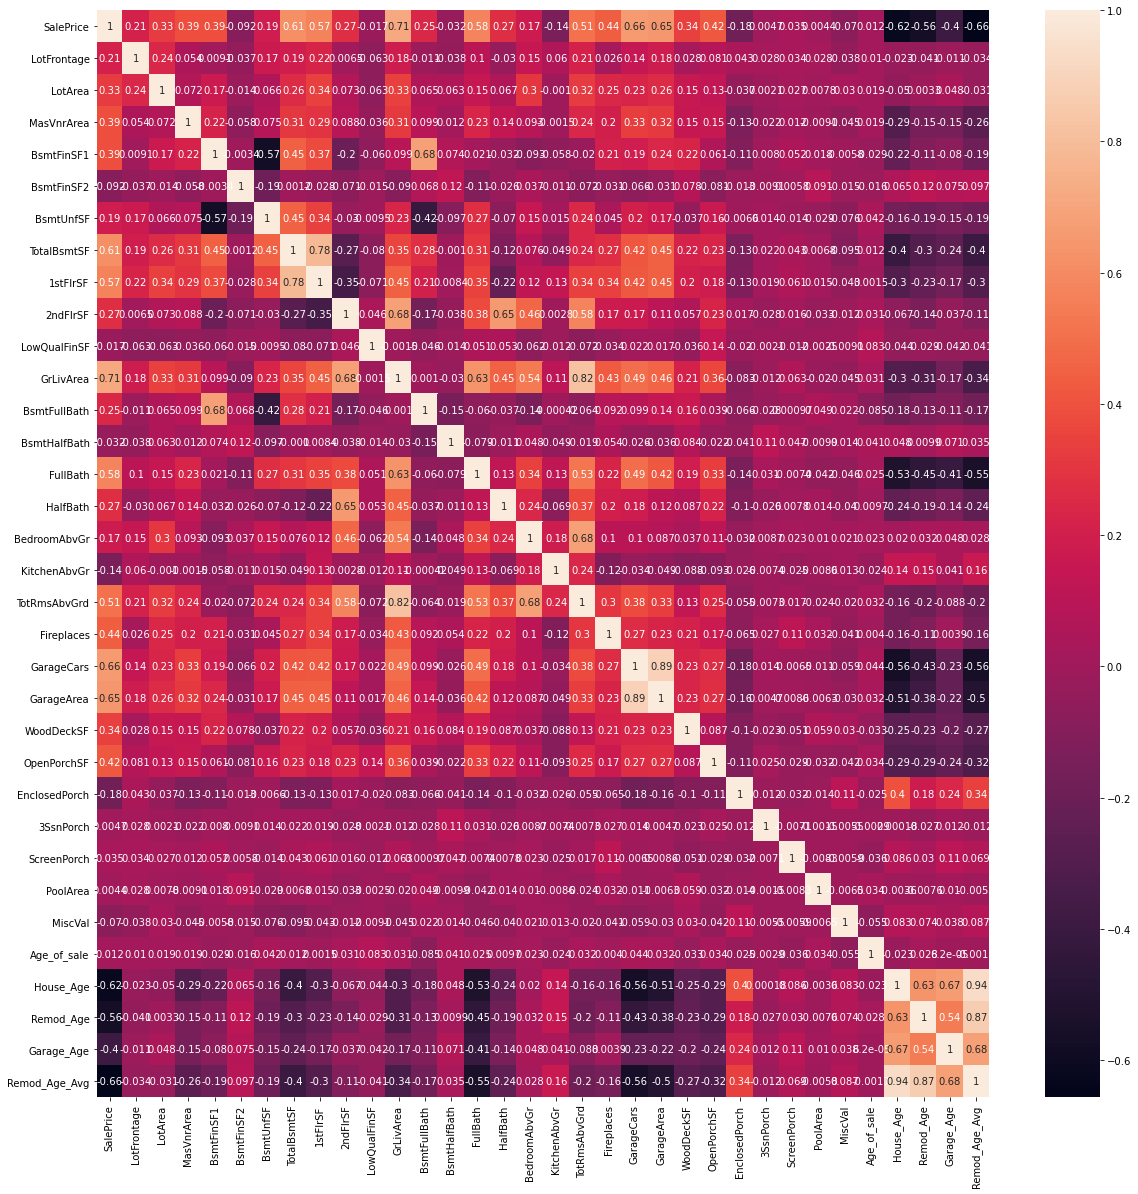

In [164]:
# Make a heatmap of the data 
plt.figure(figsize=(20,20))
sns.heatmap(data_num.corr(), annot=True)

We will start in narrowing down our features by first dropping the ones with little to no correlation to our dependent variable, sale price.

In [165]:
dropfeatures=['Age_of_sale','MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','GarageCars','KitchenAbvGr','BedroomAbvGr','BsmtHalfBath','LowQualFinSF','BsmtFinSF2','BsmtUnfSF']
data = data.drop(data[dropfeatures],axis=1)
data.head()

SalePrice  LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
0     208500         65.0     8450       196.0         706          856   
1     181500         80.0     9600         0.0         978         1262   
2     223500         68.0    11250       162.0         486          920   
3     250000         84.0    14260       350.0         655         1145   
4     307000         75.0    10084       186.0        1369         1686   

   1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  ...  MiscFeature  SaleType  \
0       856       854       1710             1  ...         None        WD   
1      1262         0       1262             0  ...         None        WD   
2       920       866       1786             1  ...         None        WD   
3      1145      1053       2198             1  ...         None        WD   
4      1694         0       1694             1  ...         None        WD   

   SaleCondition  MSSubClass  OverallQual  OverallCond  House_Age Remod_Age  \
0         Normal          60            7            5         18        18   
1         Normal          20            6            8         45        45   
2         Normal          60            7            5         20        19   
3         Normal          60            8            5         21        21   
4         Normal          20            8            5         17        16   

  Garage_Age Remod_Age_Avg  
0       18.0          18.0  
1       45.0          45.0  
2       20.0          19.5  
3       21.0          21.0  
4       17.0          16.5  

[5 rows x 62 columns]

In [166]:
data_num=data_num.drop(data_num[dropfeatures],axis=1)
data_num.head()

SalePrice  LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
0     208500         65.0     8450       196.0         706          856   
1     181500         80.0     9600         0.0         978         1262   
2     223500         68.0    11250       162.0         486          920   
3     250000         84.0    14260       350.0         655         1145   
4     307000         75.0    10084       186.0        1369         1686   

   1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  ...  HalfBath  TotRmsAbvGrd  \
0       856       854       1710             1  ...         1             8   
1      1262         0       1262             0  ...         0             6   
2       920       866       1786             1  ...         1             6   
3      1145      1053       2198             1  ...         1             9   
4      1694         0       1694             1  ...         0             7   

   Fireplaces  GarageArea  WoodDeckSF  OpenPorchSF  House_Age  Remod_Age  \
0           0         548           0           61         18         18   
1           1         460         298            0         45         45   
2           1         608           0           42         20         19   
3           1         836         192           84         21         21   
4           1         636         255           57         17         16   

   Garage_Age  Remod_Age_Avg  
0        18.0           18.0  
1        45.0           45.0  
2        20.0           19.5  
3        21.0           21.0  
4        17.0           16.5  

[5 rows x 21 columns]

<AxesSubplot:>

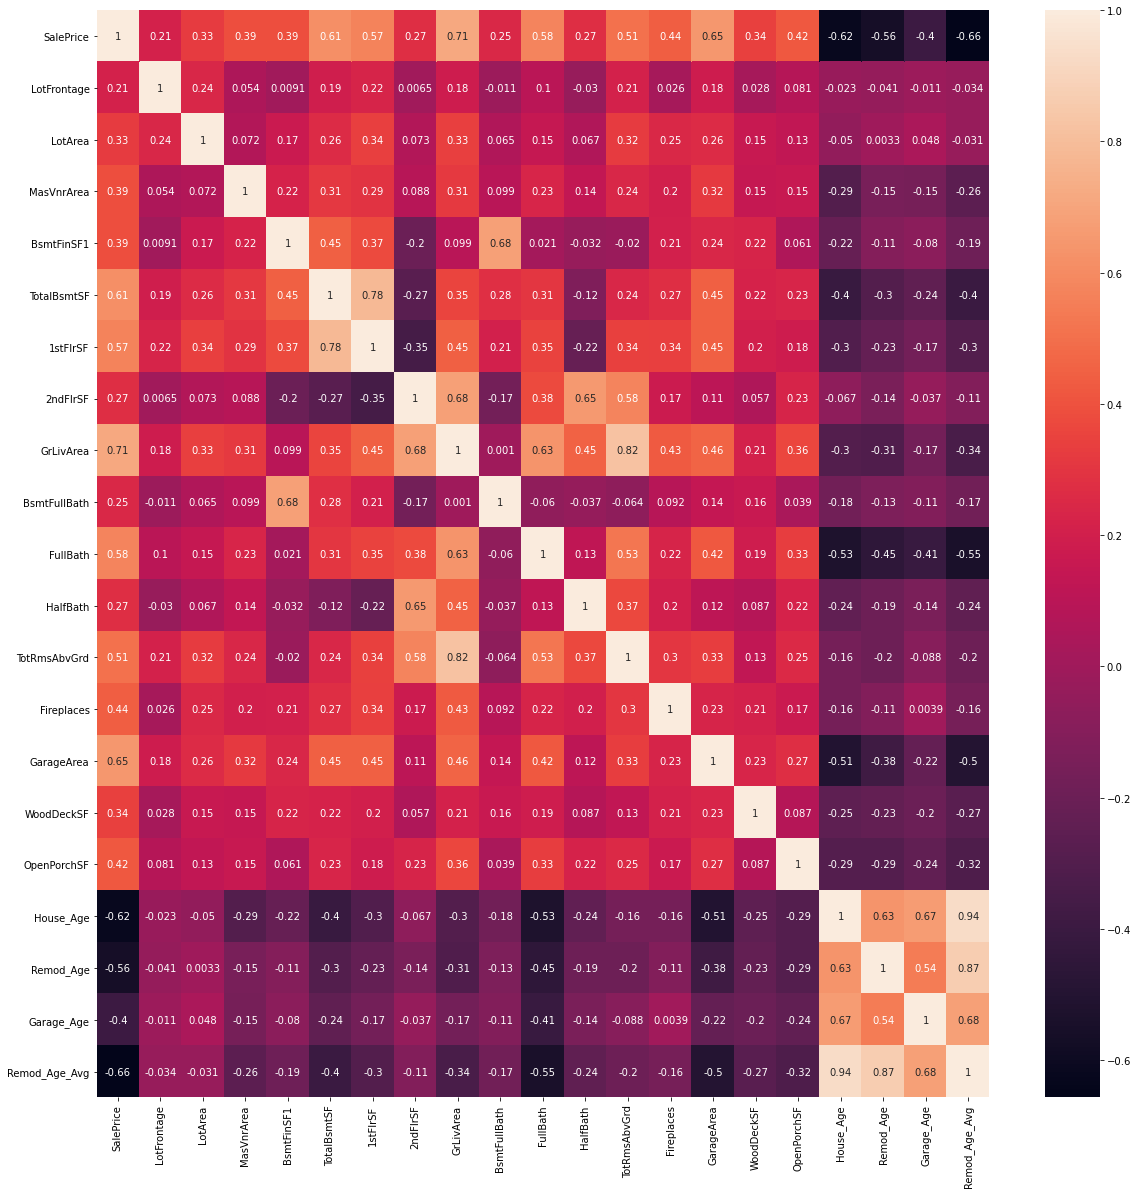

In [167]:
# Make a heatmap of the data 
plt.figure(figsize=(20,20))
sns.heatmap(data_num.corr(), annot=True)

We have several correlated independent variables, so we are going to first make some observations regarding their relationships and then determine which we can drop before preprocessing. 
Things of note:
- Newer homes seems to have larger garages, or perhaps older homes are less likely to have a garage
- 1st floor square footage is highly correlated to total basement square footage, which makes sense as basements are generally only built under the foundation of the home
- Garage cars and garage area are clearly correlated because larger garages fit more cars.
- It seems enclosed porches are more common in older homes
- GrLivArea is highly correlated with basically all features releated to rooms and above ground square footage

There is a lot of correlation between GrLiveArea, which is total square footage above ground, and several other features so we have 2 options here.
1. We drop GrLiveArea and keep the others that aren't highly correlated
2. We drop BedroomAbvGr, TotalRmsAbvGrd, 1stFlrSF, 2
The first option keeps more features, and may lead to overfitting, but could potentially lead to a more accurate model.

#### Inferential Statistics

Based off the correlation heatmap above, we're going to focus on the most correlated variables and verify their significance by calculating their pearson correlation coefficients below.

In [168]:
stats.pearsonr(data['SalePrice'],data['LotFrontage'])

(0.212169956035887, 4.871546336837841e-13)

In [169]:
stats.pearsonr(data['SalePrice'],data['LotArea'])

(0.32675202231357237, 1.0703411252217702e-29)

In [170]:
stats.pearsonr(data['SalePrice'],data['MasVnrArea'])

(0.3878762458407462, 3.9703953578943816e-42)

In [171]:
stats.pearsonr(data['SalePrice'],data['TotalBsmtSF'])

(0.6139134744846447, 1.0027358523339609e-118)

In [172]:
stats.pearsonr(data['SalePrice'],data['1stFlrSF'])

(0.5690932311636109, 1.4506618938869632e-98)

In [173]:
stats.pearsonr(data['SalePrice'],data['2ndFlrSF'])

(0.27458642742428246, 4.078934248136807e-21)

In [174]:
stats.pearsonr(data['SalePrice'],data['GrLivArea'])

(0.7094104356339839, 1.187913249181816e-174)

In [175]:
stats.pearsonr(data['SalePrice'],data['BsmtFullBath'])

(0.24686252067840664, 3.015602466964066e-17)

In [176]:
stats.pearsonr(data['SalePrice'],data['FullBath'])

(0.5762991081934687, 1.3460254883974029e-101)

In [177]:
stats.pearsonr(data['SalePrice'],data['HalfBath'])

(0.2732942387934964, 6.326926175564913e-21)

In [178]:
stats.pearsonr(data['SalePrice'],data['TotRmsAbvGrd'])

(0.5080552568944168, 1.2068424869902901e-75)

In [179]:
stats.pearsonr(data['SalePrice'],data['Fireplaces'])

(0.44322597180874845, 6.625563664399818e-56)

In [180]:
stats.pearsonr(data['SalePrice'],data['GarageArea'])

(0.6458681973190519, 3.3034007574691395e-135)

In [181]:
stats.pearsonr(data['SalePrice'],data['WoodDeckSF'])

(0.34084390908578177, 2.522997508098271e-32)

In [182]:
stats.pearsonr(data['SalePrice'],data['OpenPorchSF'])

(0.4181910104787748, 2.3634075455418656e-49)

In [183]:
stats.pearsonr(data['SalePrice'],data['House_Age'])

(-0.6201216256378377, 8.868051234134412e-122)

In [184]:
stats.pearsonr(data['SalePrice'],data['Garage_Age'])

(-0.39699720283781204, 3.1858532137435884e-44)

In [185]:
stats.pearsonr(data['SalePrice'],data['Remod_Age_Avg'])

(-0.656870829155157, 2.37074987442189e-141)

In [186]:
data_num.shape, data.shape

((1137, 21), (1137, 62))

#### Taking a closer look at the most correlated numerical variables and their relationship to Sale Price

In [201]:
data_num_corr=data[['SalePrice','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageArea','OpenPorchSF','House_Age','Garage_Age','Remod_Age_Avg']]

In [206]:
#Above DF minus the variables that are non-continuous for plotting pair plot
data_num_corr_pair=data[['SalePrice','TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea','OpenPorchSF','House_Age','Garage_Age','Remod_Age_Avg']]

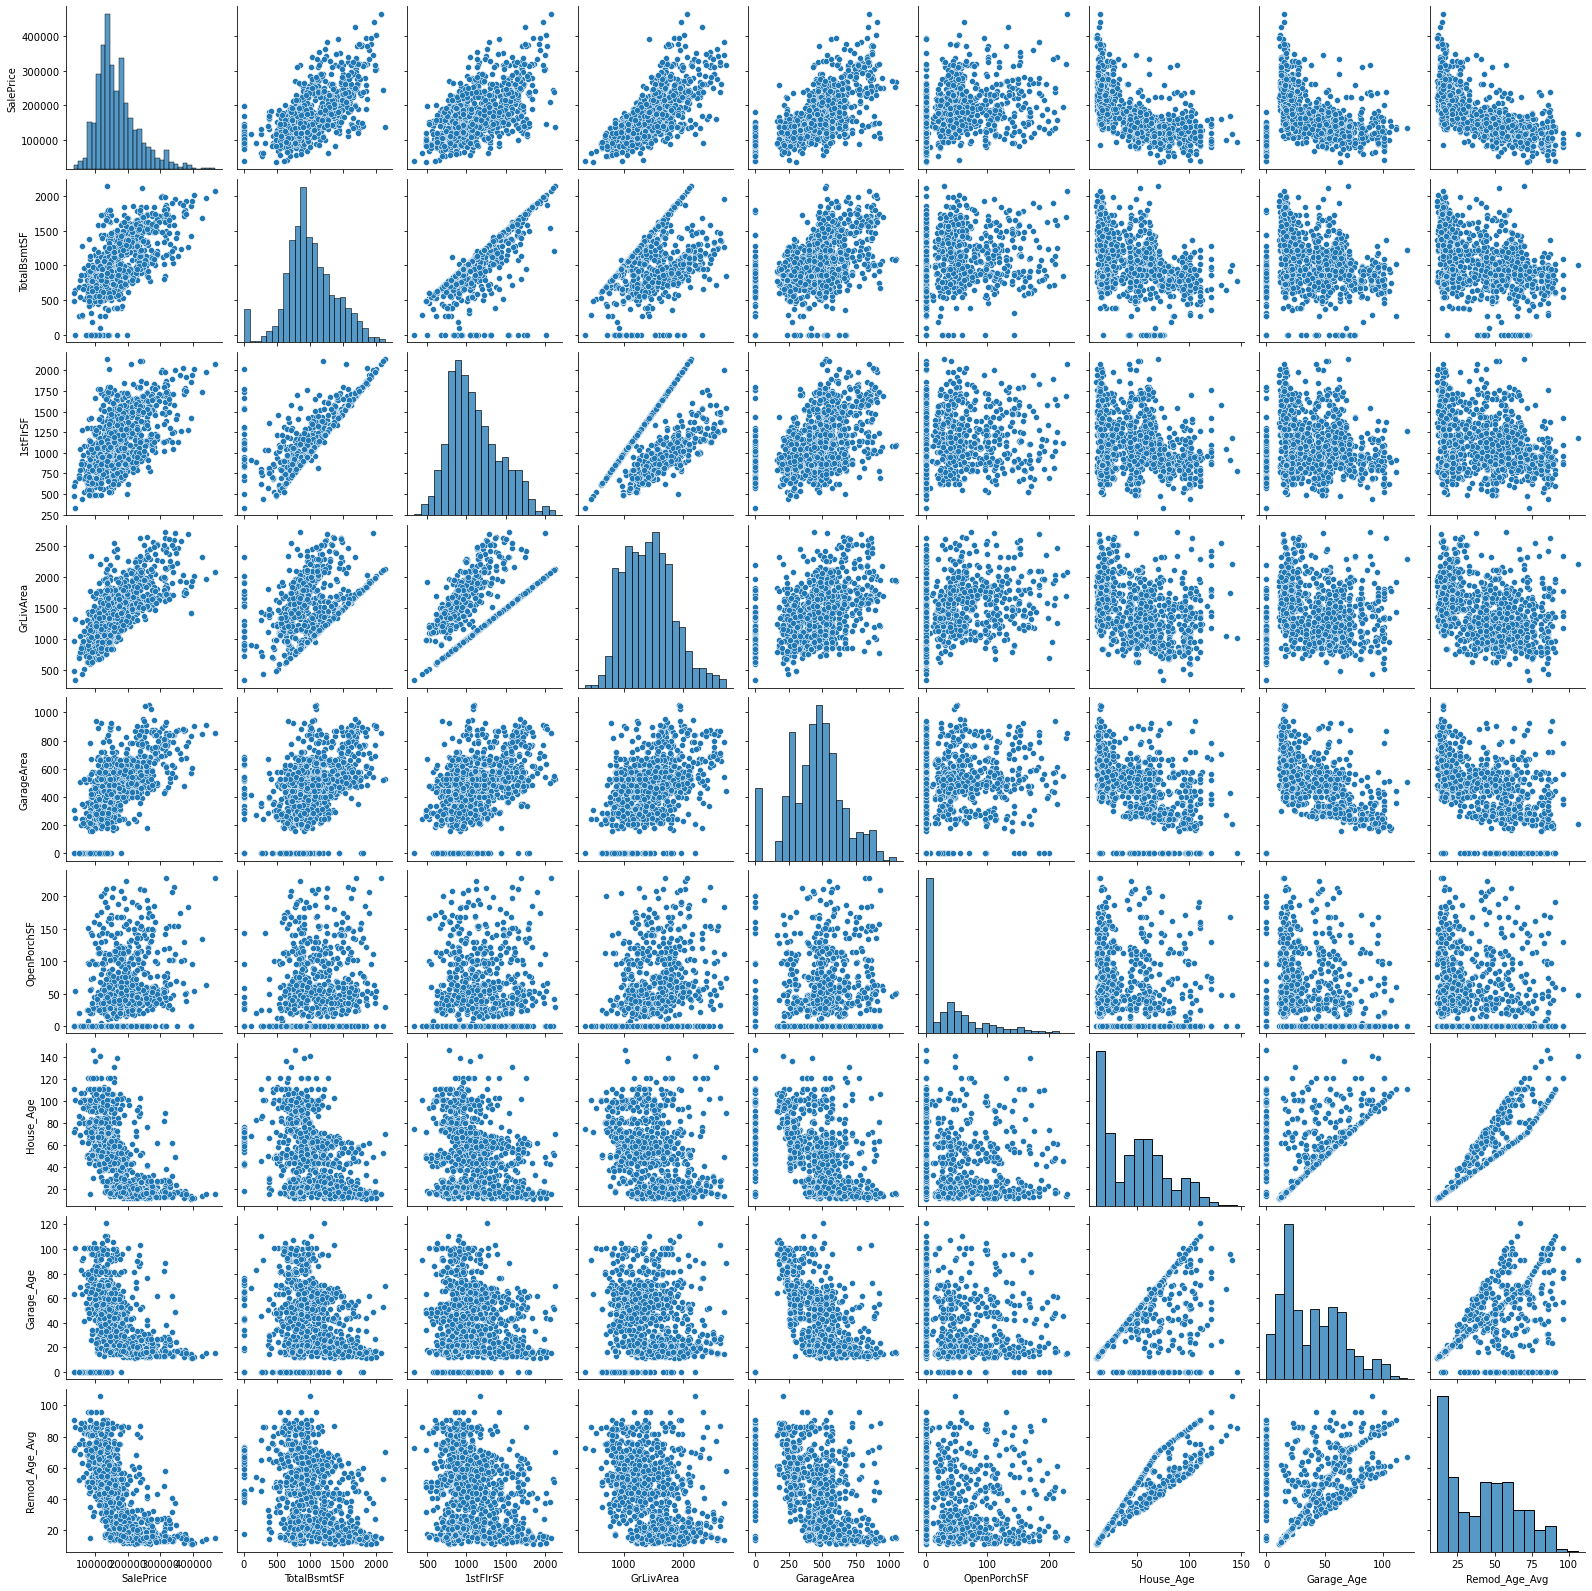

In [207]:
#Pairplot showing most correlated numerical variables
#Ex
sns.pairplot(data_num_corr_pair, palette='Set1')
plt.show()

<AxesSubplot:>

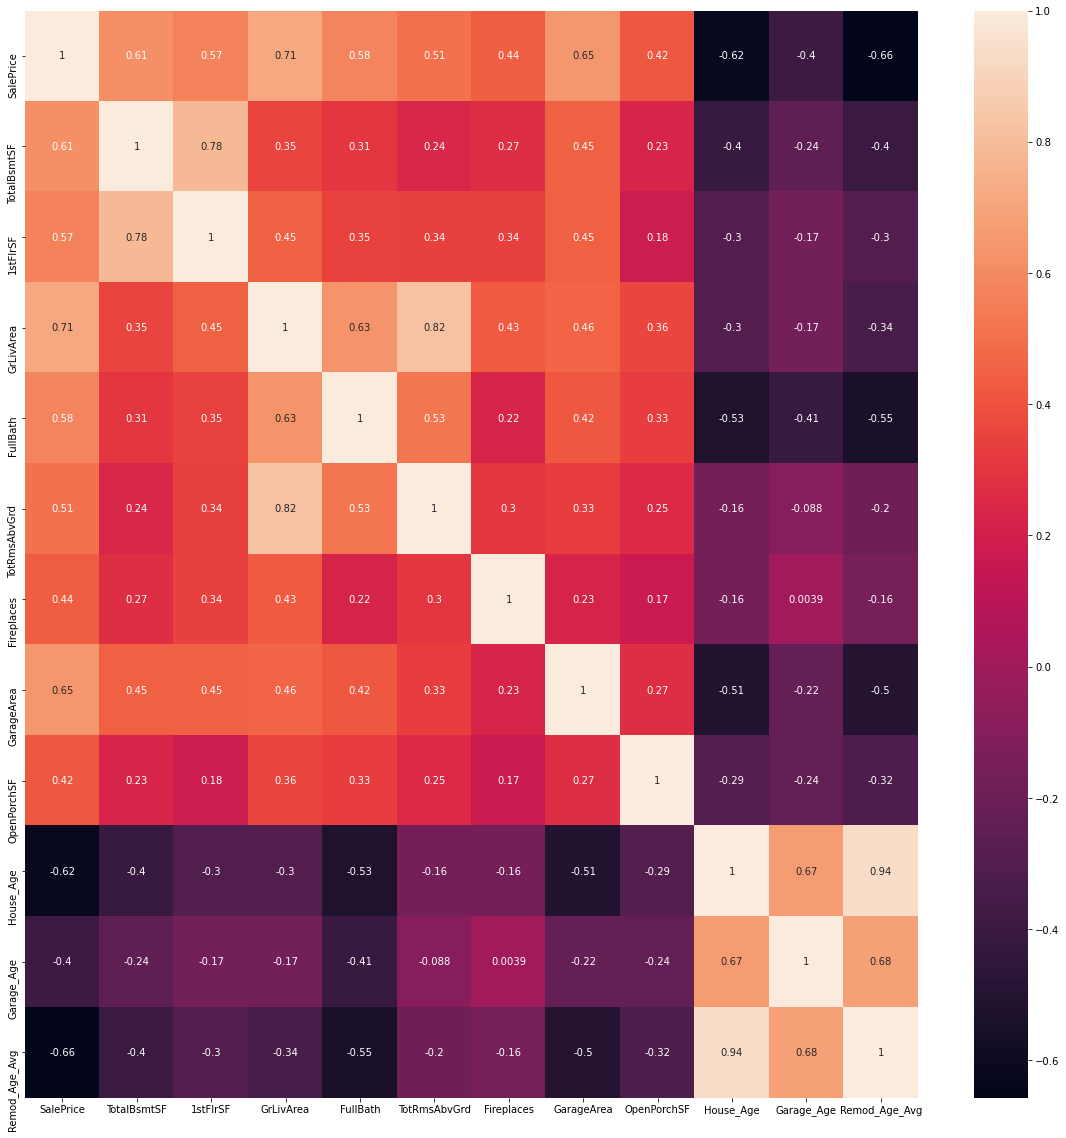

In [208]:
# Make a heatmap of the data 
plt.figure(figsize=(20,20))
sns.heatmap(data_num_corr.corr(), annot=True)

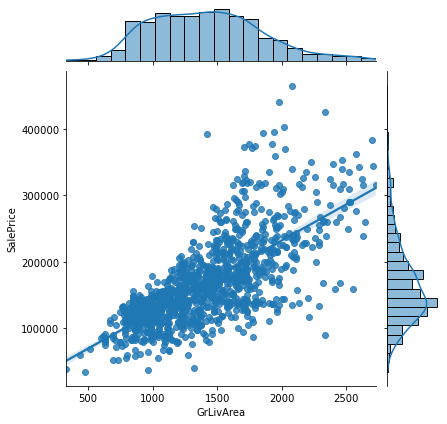

In [205]:
sns.jointplot(x='GrLivArea',y='SalePrice', data=data_num, kind="reg")

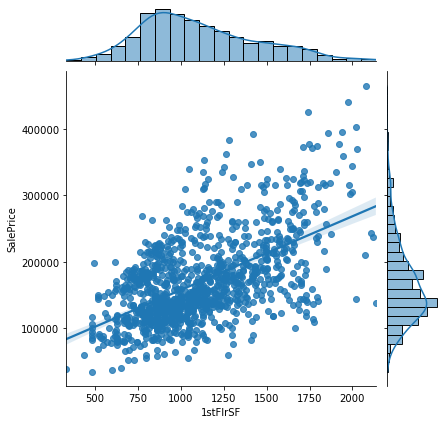

In [192]:
sns.jointplot(x='1stFlrSF',y='SalePrice', data=data_num, kind="reg")

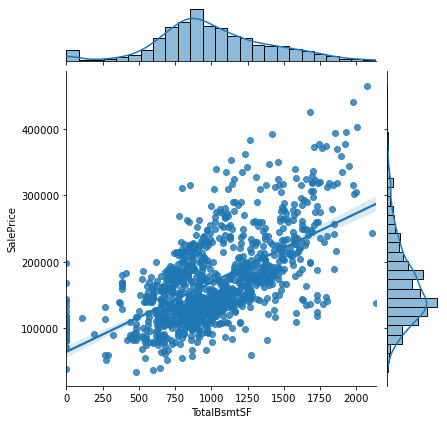

In [193]:
sns.jointplot(x='TotalBsmtSF',y='SalePrice', data=data_num, kind="reg")

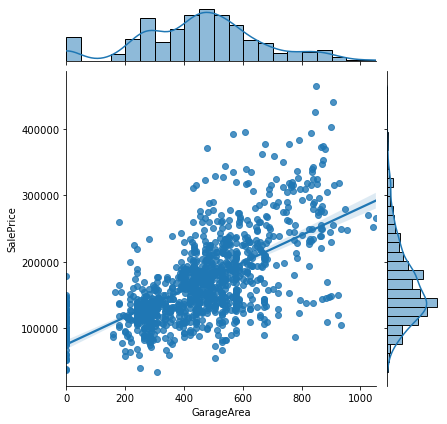

In [194]:
sns.jointplot(x='GarageArea',y='SalePrice', data=data_num, kind="reg")

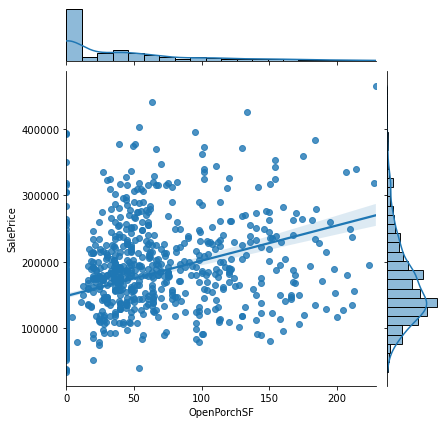

In [195]:
sns.jointplot(x='OpenPorchSF',y='SalePrice', data=data_num, kind="reg")

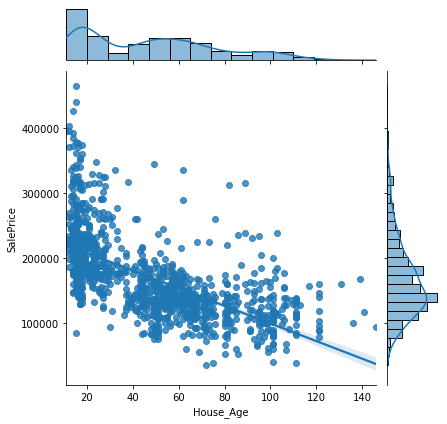

In [211]:
sns.jointplot(x='House_Age',y='SalePrice', data=data_num, kind="reg")

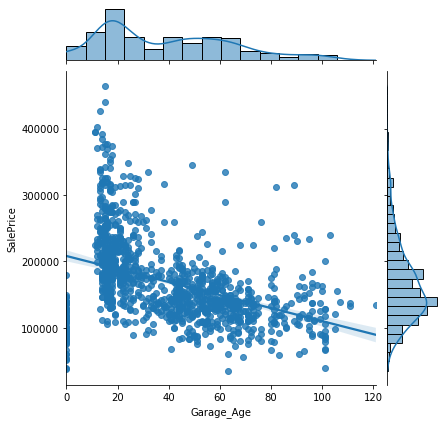

In [197]:
sns.jointplot(x='Garage_Age',y='SalePrice', data=data_num, kind="reg")

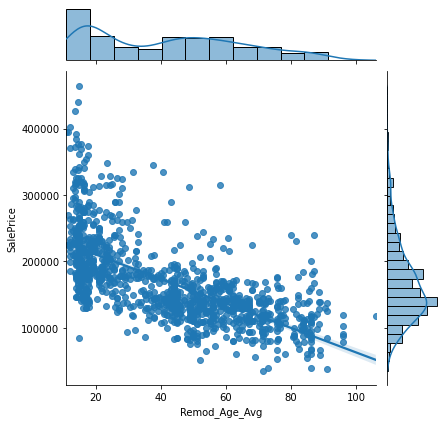

In [200]:
sns.jointplot(x='Remod_Age_Avg',y='SalePrice', data=data_num, kind="reg")

In [198]:
data.head()

SalePrice  LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
0     208500         65.0     8450       196.0         706          856   
1     181500         80.0     9600         0.0         978         1262   
2     223500         68.0    11250       162.0         486          920   
3     250000         84.0    14260       350.0         655         1145   
4     307000         75.0    10084       186.0        1369         1686   

   1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  ...  MiscFeature  SaleType  \
0       856       854       1710             1  ...         None        WD   
1      1262         0       1262             0  ...         None        WD   
2       920       866       1786             1  ...         None        WD   
3      1145      1053       2198             1  ...         None        WD   
4      1694         0       1694             1  ...         None        WD   

   SaleCondition  MSSubClass  OverallQual  OverallCond  House_Age Remod_Age  \
0         Normal          60            7            5         18        18   
1         Normal          20            6            8         45        45   
2         Normal          60            7            5         20        19   
3         Normal          60            8            5         21        21   
4         Normal          20            8            5         17        16   

  Garage_Age Remod_Age_Avg  
0       18.0          18.0  
1       45.0          45.0  
2       20.0          19.5  
3       21.0          21.0  
4       17.0          16.5  

[5 rows x 62 columns]

# Saving New Feature Data Set

In [199]:
#Saving revised data to new csv
datapath = 'C:\Springboard_\CapstoneTwo\Data Files'
save_file(data,'train_data_engineered.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "C:\Springboard_\CapstoneTwo\Data Files\train_data_engineered.csv"


## Correlations

Strongest correlations of continuous variables: GrLivArea (r=0.71), TotBsmtSF (r=0.61), House_Age (r=-0.62), GarageArea (r=0.65). 
There were also some interesting correlations between independent variables highlighted in our analysis. One such being a r=-0.53 and r=-0.56 relation between House_Age with number of full baths and garage car size, respectively. This is suggesting that newer homes have more full baths and larger garages, which is interesting. There are other, more intuitive correlations between independent variables such as General Living Area and Rooms Above Ground (r=0.82), and House Age and Garage Age (r=0.67).